# Basic Classification: Predict Action

In a *classification* problem, we aim to predict the output of a discrete value, which is in this case are the Actions

In [63]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [64]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [66]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

### Get the data
First Import it using pandas

In [68]:

raw_dataset = pd.read_csv("./fromStateToAction_df2.csv")

dataset = raw_dataset.copy()
for index, row in dataset.iterrows():
    CS_array =np.array(eval(row["current_state"]))
    dataset["current_state"][index] = CS_array
    GS_array =np.array(eval(row["goal_state"]))
    dataset["goal_state"][index] = GS_array
    dataset["out_action"][index] =  int(dataset["out_action"][index])

dataset["Difference"] =   dataset["goal_state"]-dataset["current_state"]

dataset[["C0",'C1',"C2","C3",'C4',"C5"]] = pd.DataFrame(dataset.current_state.values.tolist(), index= dataset.index)
dataset[["D0",'D1',"D2","D3",'D4',"D5"]] = pd.DataFrame(dataset.Difference.values.tolist(), index= dataset.index)


dataset.head()

,id_camino,id_in_seq,current_state,goal_state,out_action,timesteps,Difference,C0,C1,C2,C3,C4,C5,D0,D1,D2,D3,D4,D5
0,0,0,"[0, 0, 1, 0, 0, 0]","[1848.0120943540667, -352.38269073325876, 2.43...",5,315.345581,"[1848.0120943540667, -352.38269073325876, 1.43...",0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1848.012094,-352.382691,1.434321,0.086841,-0.154525,0.000072
1,0,1,"[374.6557815617177, -36.35881681760387, 1.2092...","[1848.0120943540667, -352.38269073325876, 2.43...",1,315.345581,"[1473.356312792349, -316.02387391565486, 1.225...",374.655782,-36.358817,1.209224,0.180633,0.075389,0.001017,1473.356313,-316.023874,1.225097,-0.093792,-0.229914,-0.000945
2,0,2,"[1095.9133891121612, -208.31370508010988, 2.31...","[1848.0120943540667, -352.38269073325876, 2.43...",1,315.345581,"[752.0987052419055, -144.06898565314887, 0.121...",1095.913389,-208.313705,2.312686,0.088155,-0.184493,-0.000866,752.098705,-144.068986,0.121635,-0.001314,0.029969,0.000937
3,1,0,"[0, 0, 1, 0, 0, 0]","[2038.2603000161923, -376.1068761324533, 2.426...",2,315.345581,"[2038.2603000161923, -376.1068761324533, 1.426...",0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2038.260300,-376.106876,1.426582,0.086971,-0.150092,0.000005
4,1,1,"[557.2873618367145, -88.35404417578944, 1.9044...","[2038.2603000161923, -376.1068761324533, 2.426...",1,315.345581,"[1480.9729381794778, -287.75283195666384, 0.52...",557.287362,-88.354044,1.904406,0.117667,-0.007043,0.001597,1480.972938,-287.752832,0.522176,-0.030696,-0.143049,-0.001592


### Clean the data

The dataset contains a few unknown values.

In [70]:
dataset.isna().sum()

id_camino        0
id_in_seq        0
current_state    0
goal_state       0
out_action       0
timesteps        0
Difference       0
C0               0
C1               0
C2               0
C3               0
C4               0
C5               0
D0               0
D1               0
D2               0
D3               0
D4               0
D5               0
dtype: int64

To keep this initial tutorial simple drop those rows.

In [72]:
dataset = dataset.dropna()

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [74]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [76]:
train_labels = train_dataset["out_action"]
test_labels = test_dataset["out_action"]

train_data = train_dataset[["D0",'D1',"D2","D3",'D4',"D5"]]
test_data = test_dataset[["D0",'D1',"D2","D3",'D4',"D5"]]


It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [78]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [80]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[6]),
    layers.Dense(64, activation='relu'),
    layers.Dense(6)
  ])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [82]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 390       
Total params: 4,998
Trainable params: 4,998
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [84]:
example_batch = train_data[:10][0:8]
example_result = model.predict(example_batch)
example_result

array([[-112.23742   ,   -3.7727017 ,   -2.239768  ,   -2.899498  ,
          -5.9881206 ,   -9.796126  ],
       [-260.26688   , -190.14136   ,   -1.0516084 ,   -3.0105844 ,
          -6.5352235 ,   -8.574704  ],
       [-109.33063   , -113.91372   ,    0.34135202,   -1.311762  ,
          -4.435246  ,   -7.0169516 ],
       [ -34.767273  ,    4.2562404 ,  -33.945644  ,  -23.24988   ,
          -9.027986  ,   -2.423667  ],
       [-117.68177   , -113.71298   ,  -20.713995  ,   -1.8597931 ,
          -4.867434  ,   -7.8600883 ],
       [ -83.06198   ,   -1.6045613 ,   -2.1421306 ,   -2.6760352 ,
          -4.7371235 ,   -8.118998  ],
       [ -61.83461   ,  -61.07481   ,  -87.33406   ,  -18.131285  ,
          -2.404469  ,   -1.1380174 ],
       [-238.09306   , -186.53996   ,   -1.1123133 ,   -2.5134583 ,
          -6.1416473 ,   -7.4753327 ]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [86]:
EPOCHS = 1000

history = model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.8424,  loss:0.4148,  val_accuracy:0.8421,  val_loss:0.3874,  
....................................................................................................
Epoch: 100, accuracy:0.8470,  loss:0.4065,  val_accuracy:0.8241,  val_loss:0.4405,  
....................................................................................................
Epoch: 200, accuracy:0.8385,  loss:0.4195,  val_accuracy:0.8503,  val_loss:0.4118,  
....................................................................................................
Epoch: 300, accuracy:0.8437,  loss:0.3979,  val_accuracy:0.8340,  val_loss:0.4045,  
....................................................................................................
Epoch: 400, accuracy:0.8455,  loss:0.4053,  val_accuracy:0.8589,  val_loss:0.3700,  
....................................................................................................
Epoch: 500, accuracy:0.8418,  loss:0.4126,  val_accuracy:0.8464,  val_l

Visualize the model's training progress using the stats stored in the `history` object.

In [88]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
995,0.418187,0.850172,0.386749,0.856285,995
996,0.380358,0.860575,0.402002,0.851995,996
997,0.443120,0.846847,0.413410,0.853711,997
998,0.386455,0.858644,0.375813,0.869155,998
999,0.413031,0.848348,0.395362,0.847705,999


In [90]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'Accuracy [Action]')

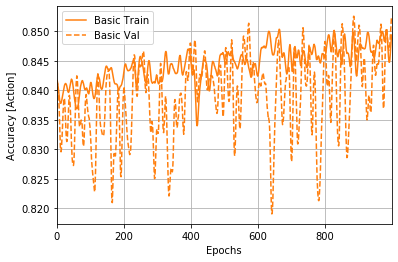

In [92]:
plotter.plot({'Basic': history}, metric = "accuracy")
plt.ylabel('Accuracy [Action]')

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [94]:

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.8541,  loss:0.3962,  val_accuracy:0.8331,  val_loss:0.4581,  
.................

Text(0, 0.5, 'Accuracy [Action]')

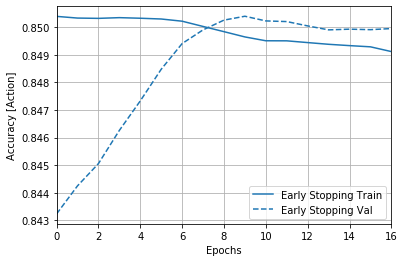

In [107]:
plotter.plot({'Early Stopping': early_history}, metric = "accuracy")
plt.ylabel('Accuracy [Action]')

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [98]:
loss, Acc = model.evaluate(test_data, test_labels, verbose=2)

print("Testing set accuracy: {:5.2f}".format(Acc))

2914/2914 - 0s - loss: 0.3890 - accuracy: 0.8662
Testing set accuracy:  0.87


### Make predictions

Finally, predict Action values using data in the testing set:

First we obtain the predicted action with the most probability with argmax and a softmax function

In [100]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [102]:
test_predictions = probability_model.predict(test_data)

In [ ]:
predicted_action = []
for i in test_predictions:
    predicted_action.append(np.argmax(i))

Text(0, 0.5, 'Predictions [Action]')

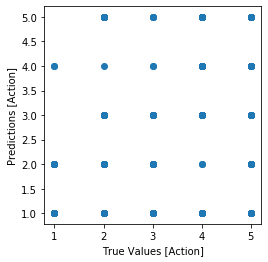

In [105]:
test_predictions = predicted_action

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Action]')
plt.ylabel('Predictions [Action]')



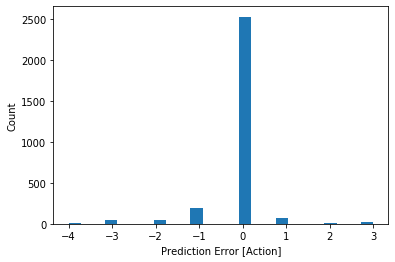

In [106]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Action]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.